# **Módulo 47 - Series de Tiempo II**

En este módulo profundizaremos en el análisis y modelado de series temporales, aplicando conceptos avanzados para estudiar fenómenos ecónomicos y del mercado de valores. Exploraremos varios modelos de predicción, cada uno con sus características y aplicaciones.

## **Movimiento Geométrico Browniano**

Este modelo se utiliza para predecir precios de acciones, caracterizado por su falta de memoria. Las predicciones futuras dependen únicamente de la volatilidad actual, utilizando un proceso aleatorio para simular posibles trayectorias de precios.

## **Modelos de Reversión a la Media**

Aplicado a la predicción de tasas de interés, este modelo busca que las variables oscilen alrededor de un valor medio a largo plazo. Se exploran parámetros como la velocidad de regresión y el nivel de largo plazo, destacando el modelo Vasicek.

## **Modelos Autoregresivos y Promedios Móviles**

Estos modelos utilizan observaciones de periodos anteriores y errores pasados para predecir valores futuros. se discuten las condiciones y restricciones de los modelos AR y MA, así como su combinación en el modelo ARMA.

___
# **Series de Tiempo II**


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

In [46]:
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import randn, seed
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

In [47]:
df_apple = pd.read_csv(r'C:\Users\danielortega\OneDrive - HOTELERA YALKUITO SA DE CV\Desktop\No Borrar Daniel\30 Data Analyst - Curso\53_Módulo_47_Series_de_Tiempo_II\Modulo_47_Series_de_Tiempo_II\Analista de datos AAPL_2006-01-01_to_2018-01-01_M30.csv',
                       index_col='Date', parse_dates=True)
df_google = pd.read_csv(r'C:\Users\danielortega\OneDrive - HOTELERA YALKUITO SA DE CV\Desktop\No Borrar Daniel\30 Data Analyst - Curso\53_Módulo_47_Series_de_Tiempo_II\Modulo_47_Series_de_Tiempo_II\Analista de datos GOOGL_2006-01-01_to_2018-01-01_M31.csv',
                        index_col='Date', parse_dates=True)

## **Conceptos Preliminares**

**Autocorrelación**
- La función de autocorrelación (ACF) mide qué tan correlacionada una serie está con ella misma.
- Las unidades de la ACF son los diferentes periodos de tiempo (lags).
- Se le puede interpretar como una regresión de la serie cons sus lags anteriores.
- Los términos se pueden interpretar como una regresión simple, es decir, la contribución de un cambio en cada lag, mientras se mantienen a los demás constantes. 

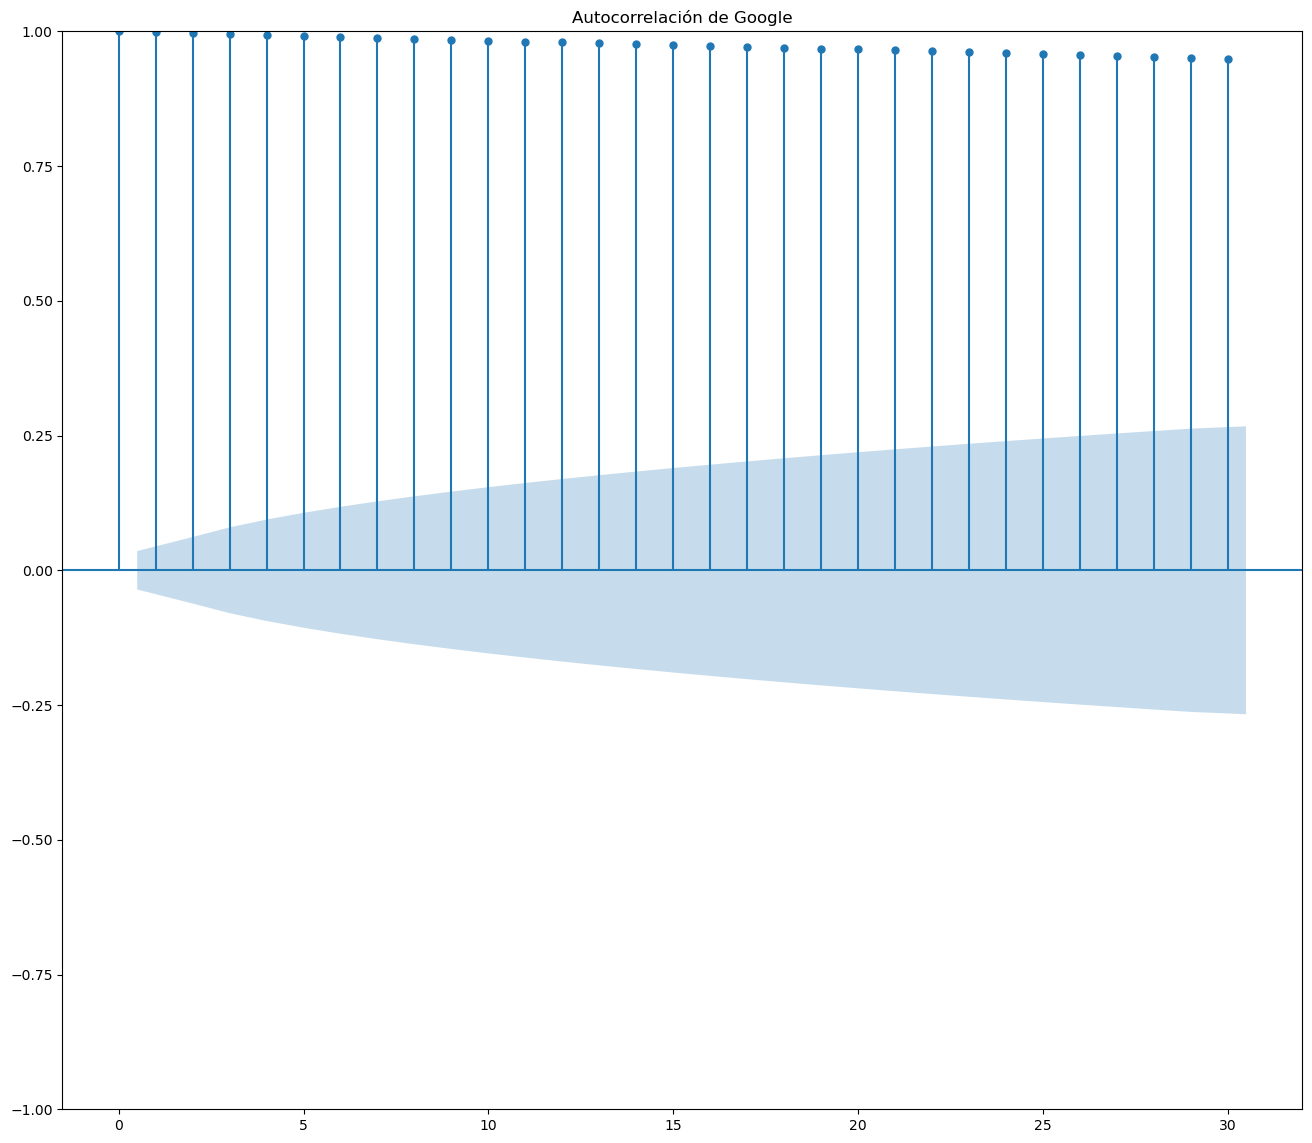

In [48]:
plot_acf(df_google['Close'], lags=30, title='Autocorrelación de Google')
plt.show()

## **Insights**
- La mayoría de lags están cerca del 1 lo que quiere decir que tienen alta importancia.
- Se puede ver además una tendencia a la baja, lo que nos indica que para la predicción, cada lag disminuye su fuerza (se incrementa el área sombrada).

___
# **Función Parcial de Autocorrelación**

- Esta función genera la correlación parcial entre los valores de una serie de tiempo y sus lags anteriores. 
- La correlación parcial es un cálculo de correlación que toma en cuenta las observaciones de la serie de tiempo separadas por sus lags, luego de ajustar por la presencia de otros términos con lags más pequeños (lo que la diferencia de ACF).
- También nos indica cuál es la importancia de los lags en la predicción.

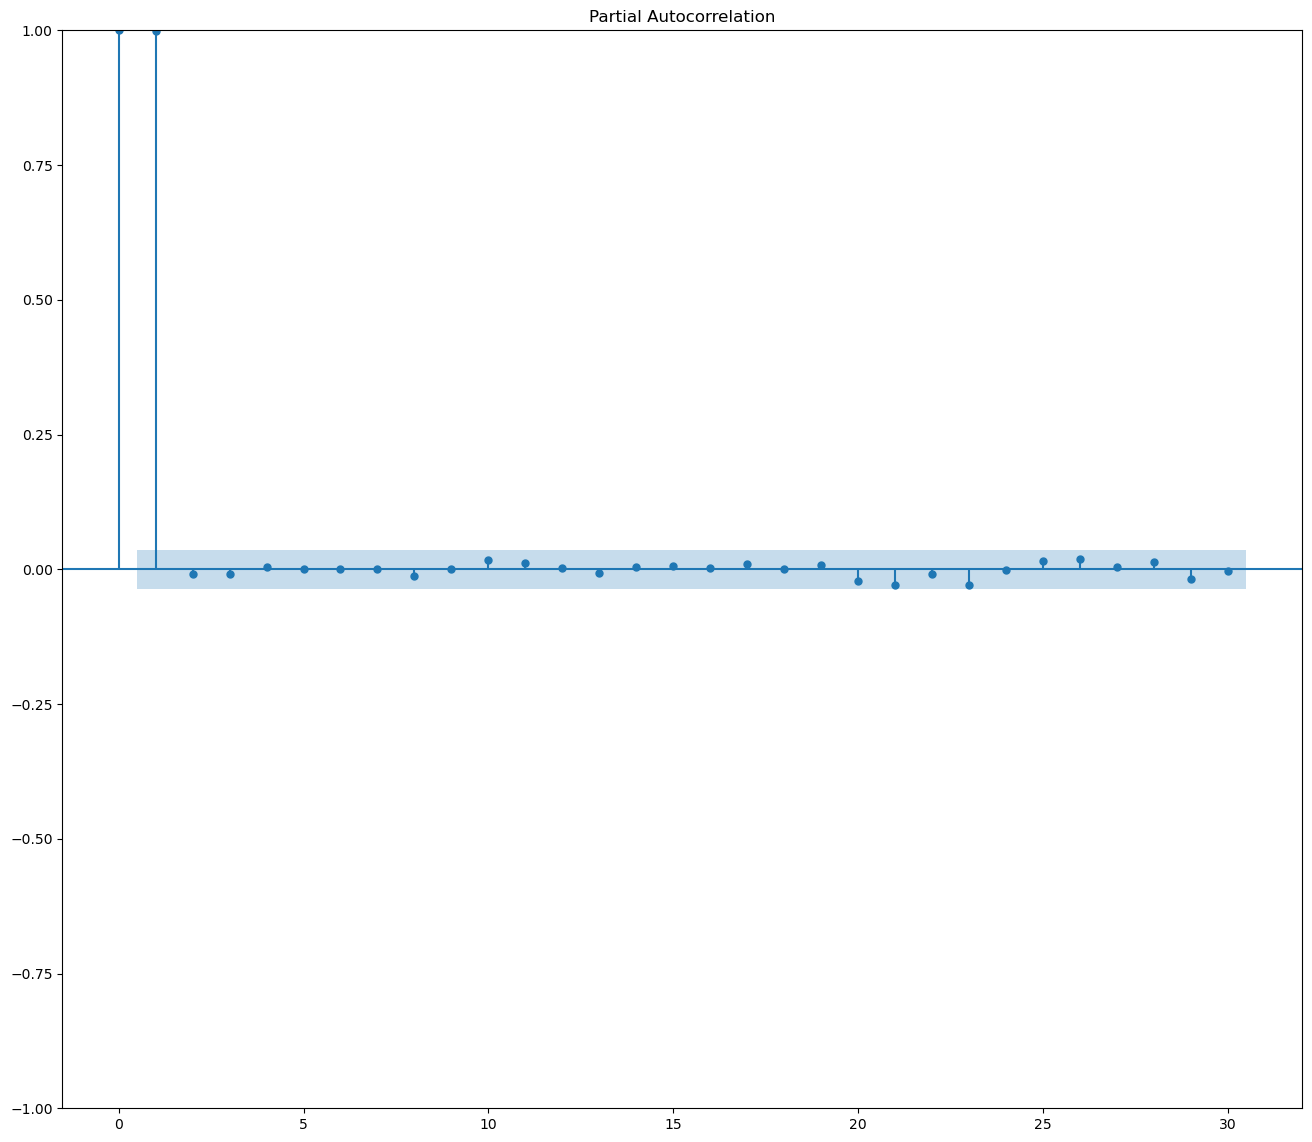

In [49]:
plot_pacf(df_google['Close'], lags=30)
plt.show()

## **Insights**
- Se como el t0 y el t1 tienen una alta correlación parcial (PACF), mientras que los demás periodos no tanto.

___
# **White Noise**
- Es una generación de información aleatoria con intensidades similares en cada frecuencia.
- Es una secuencia de variables aleatorias, no relacionadas, con una media constante (estacionarias) y varianza limitada.
- Además tiene cero correlación en sus lags (ACF).

Text(0.5, 1.0, 'White Noise')

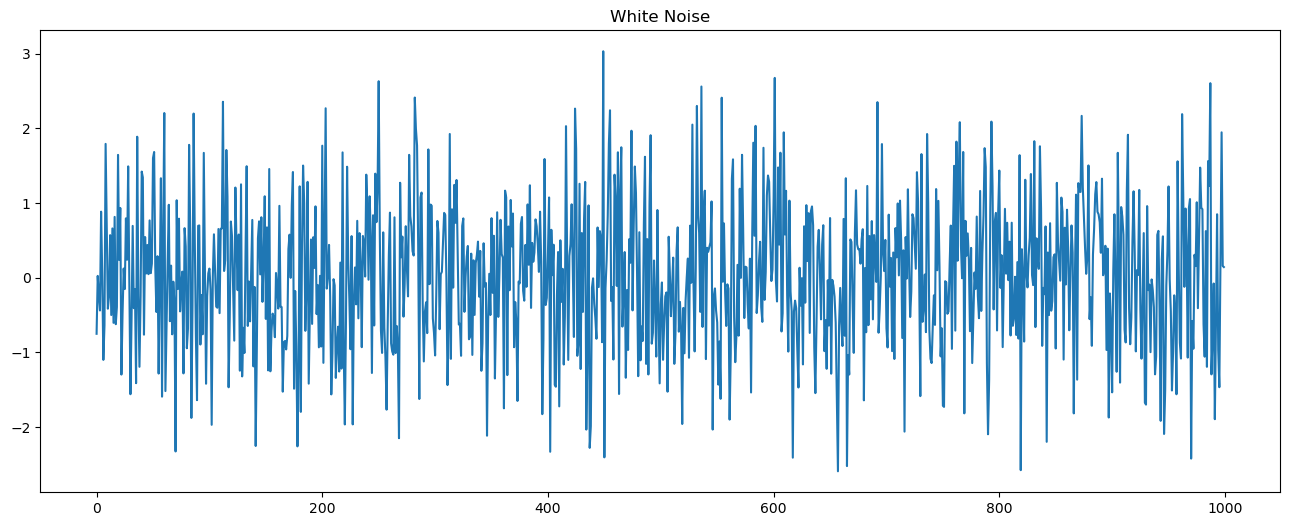

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
plt.plot(white_noise)
plt.title('White Noise')

- Visualización de autocorrelación de ruido blanco.
- Según las definiciones anteriore, debería ser cero, que es lo que se puede apreciar en el gráfico.

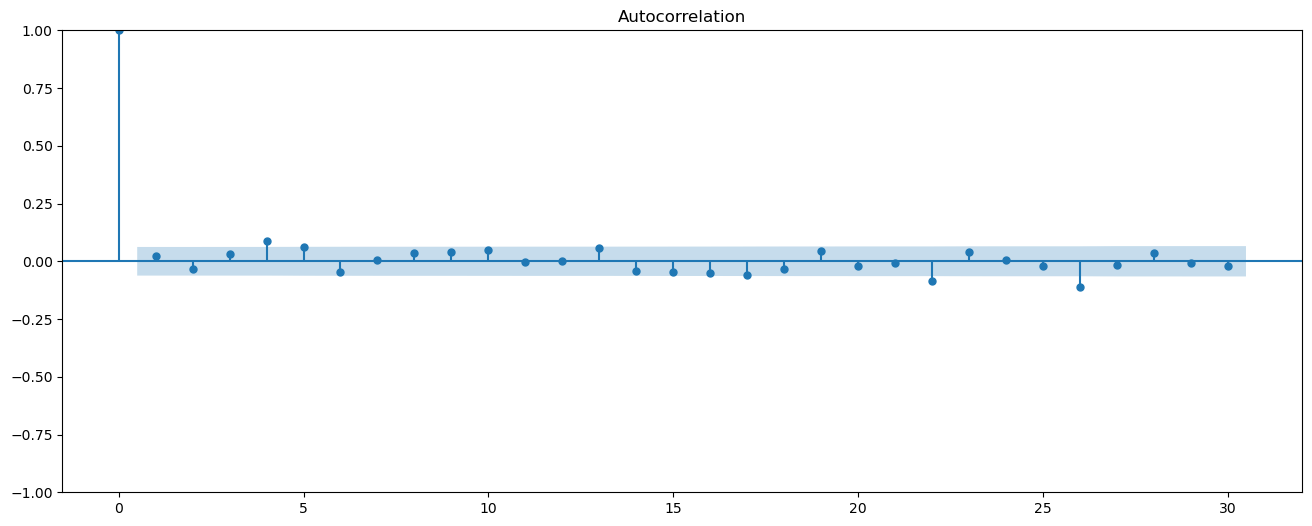

In [51]:
plot_acf(white_noise, lags=30)
plt.show()

___
# **Serie Geometric Brownian Motion**

- Serie aleatoria utilizada para predecir precios de stocks y movimientos tipo random walk.

In [52]:
from scipy.stats import norm
import pandas as pd

In [53]:
# Parámetros del proceso
delta = 0.25
dt = 0.1

# Punto inicio
x = 0.0
xini = 0

# Número de iteraciones
n = 10

**Genera los distintos puntos de la serie**

In [54]:
for k in range(n):
    x = x + norm.rvs(scale=delta**2*dt)
    print(f'Iteración {k}, valor {x}')

Iteración 0, valor -0.004001863365684217
Iteración 1, valor 0.004659933343798538
Iteración 2, valor 0.01352600132897895
Iteración 3, valor 0.015048416193506803
Iteración 4, valor 0.021850191666185972
Iteración 5, valor 0.01428121810675182
Iteración 6, valor 0.003570185113259969
Iteración 7, valor -0.0012416539466387098
Iteración 8, valor -0.00901105008600258
Iteración 9, valor -0.005384580469786667


In [55]:
# Número de trayectorias
ntra = 10

# Número de iteraciones
n = 20

# Lista temporal para acumular todo
dfres_list = []


**Genera los puntos iniciales**

In [56]:
for i in range(ntra+1):
    df2 = {'traj': i, 'nsample': 0, 'sample': xini}
    dfres_list.append(df2)

**Generar las trayectorias en un DataFrame**

In [57]:
for i in range(ntra+1):
    x = xini  # inicializa en cada trayectoria
    for k in range(1, n+1):
        x = x + norm.rvs(scale=delta**2 * dt)
        df2 = {'traj': i, 'nsample': k, 'sample': x}
        dfres_list.append(df2)

**Convertimos todo a un DataFrame**

In [58]:
dfres = pd.DataFrame(dfres_list)

print(dfres.head(15))

    traj  nsample    sample
0      0        0  0.000000
1      1        0  0.000000
2      2        0  0.000000
3      3        0  0.000000
4      4        0  0.000000
5      5        0  0.000000
6      6        0  0.000000
7      7        0  0.000000
8      8        0  0.000000
9      9        0  0.000000
10    10        0  0.000000
11     0        1  0.001788
12     0        2  0.004192
13     0        3 -0.001975
14     0        4  0.011115


**Plot de las muestras**

<Axes: xlabel='nsample', ylabel='sample'>

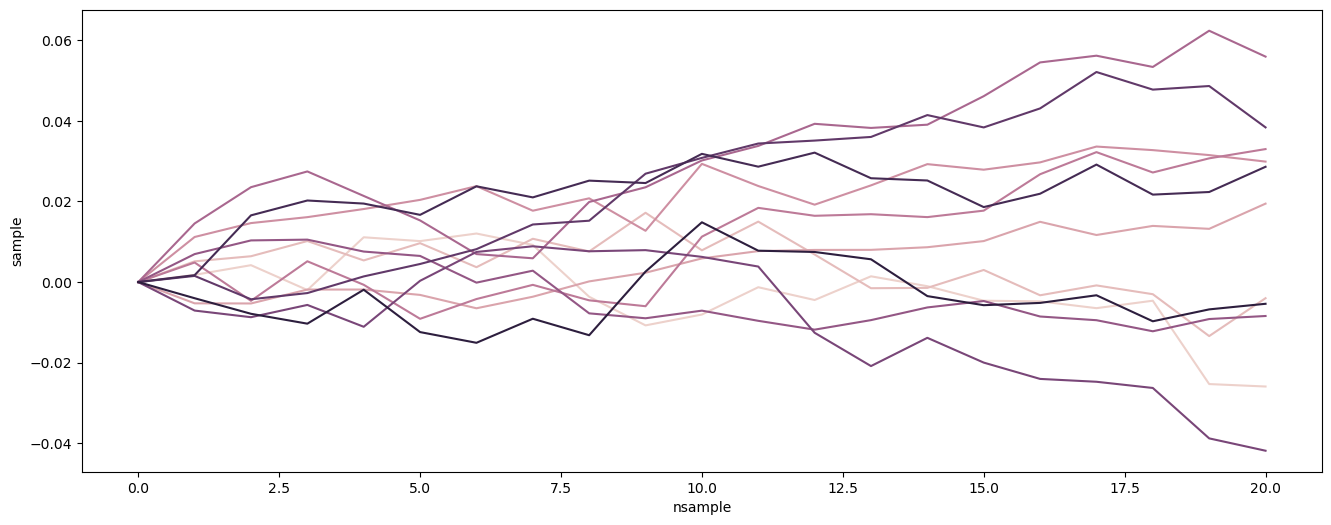

In [59]:
import seaborn as sns
sns.lineplot(data=dfres, x='nsample', y='sample', hue='traj', legend=None)

**Se pueden obtener las trayectorias**

In [60]:
pd.pivot_table(dfres, index='nsample', columns='traj', values='sample')

traj,0,1,2,3,4,5,6,7,8,9,10
nsample,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001788,0.005145,-0.005278,0.011189,0.004855,0.014546,0.006944,-0.007074,0.001530,0.001711,-0.004010
2,0.004192,0.006411,-0.005312,0.014641,-0.004656,0.023552,0.010339,-0.008718,-0.004269,0.016558,-0.007873
3,-0.001975,0.010185,-0.001856,0.016115,0.005159,0.027457,0.010533,-0.005674,-0.002731,0.020246,-0.010325
4,0.011115,0.005372,-0.001854,0.018130,-0.000676,0.021378,0.007572,-0.011095,0.001403,0.019483,-0.001901
5,0.010169,0.009657,-0.003186,0.020400,-0.009120,0.015299,0.006487,0.000313,0.004490,0.016683,-0.012414
6,0.012048,0.003692,-0.006506,0.023808,-0.004214,0.006946,-0.000142,0.007472,0.008170,0.023770,-0.015072
7,0.009216,0.010747,-0.003637,0.017712,-0.000691,0.005900,0.002829,0.008884,0.014292,0.021018,-0.009101
8,-0.003648,0.007598,0.000167,0.020786,-0.004532,0.019883,-0.007764,0.007642,0.015230,0.025177,-0.013192


**Se puede obtener las medias de las trayectorias**

In [61]:
pd.pivot_table(dfres, columns=['nsample'], aggfunc='mean')

nsample,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
sample,0.0,0.00285,0.004079,0.006103,0.006266,0.005343,0.005452,0.007015,0.006122,0.008368,...,0.014774,0.012329,0.011287,0.012153,0.011534,0.013195,0.015479,0.012808,0.010488,0.010886
traj,5.0,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


_____
# **Serie de Reversión a la Media**

- Conocido como el Modelo Vasicek.
- Muy utilizada para predecir tasas de Bancos Centrales, niveles de actividad económicos.

In [62]:
def mod_vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    for i in range(N):
        dr = K*(theta - rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] +dr)
    return range(N+1), rates


**Parámetros para la serie de tiempo**

In [63]:
r0= 0.1875
K = 0.2
theta = 0.04
sigma = 0.012
T = 10
seed = np.random.randint(100, 900)
N = 1000

**Llama a la función Vasicek**

In [64]:
x, y = mod_vasicek(r0, K, theta, sigma, T, N, seed)

**Generación de gráfica del modelo de Reversión a la media**

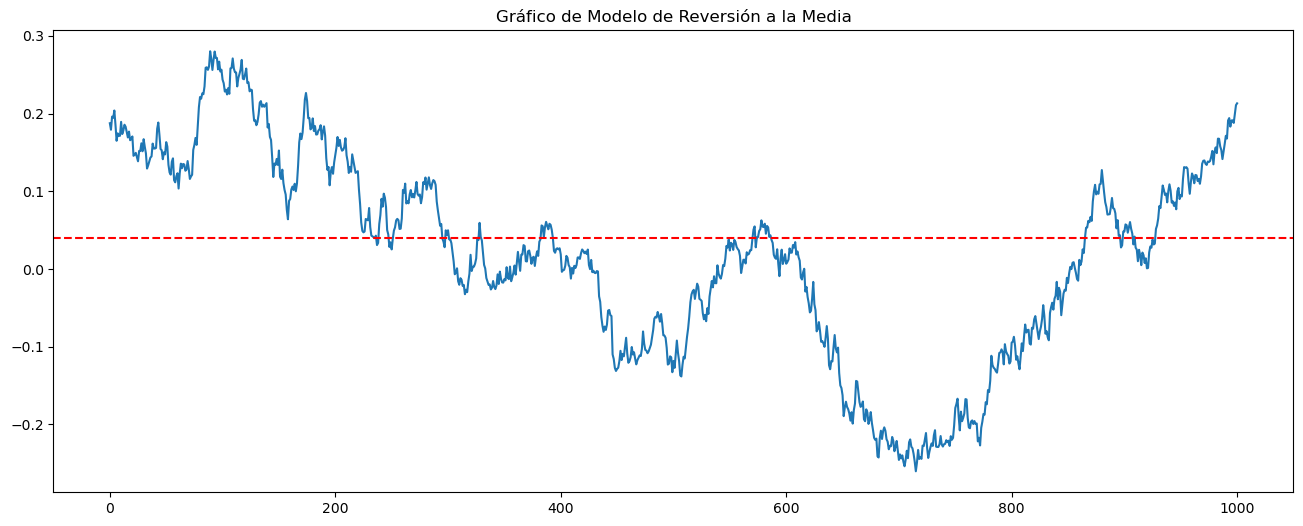

In [65]:
plt.plot(x,y)
plt.title('Gráfico de Modelo de Reversión a la Media')
plt.axhline(theta, color='red', linestyle='--')
plt.show()

## **Insights**

- Se puede ver el gráfico como se oscila alrededor de la media.
- Esto ocurre de manera aleatoria también.

_____

# **Serie de Tiempo Autoregresivo (AR)**

- Representación de un tipo de proceso aleatorio con regresiones sobre las mismas variables.
- Utilizadas para describir procesos de variación de tiempo en la naturaleza, economía, etc. 
- Especifica que la variable de salida depende linealmente de sus valores previos además de un término estocástico (no predecible).

**Configuración de la Serie Autoregresiva AR**

- Se generarán  4 diferentes gráficas, con dos niveles de AR: AR(1) y AR(2).
- Se usa la función ArmaProcess, además de la función generate_sample

# **Generación de la Serie de Tiempo AR**

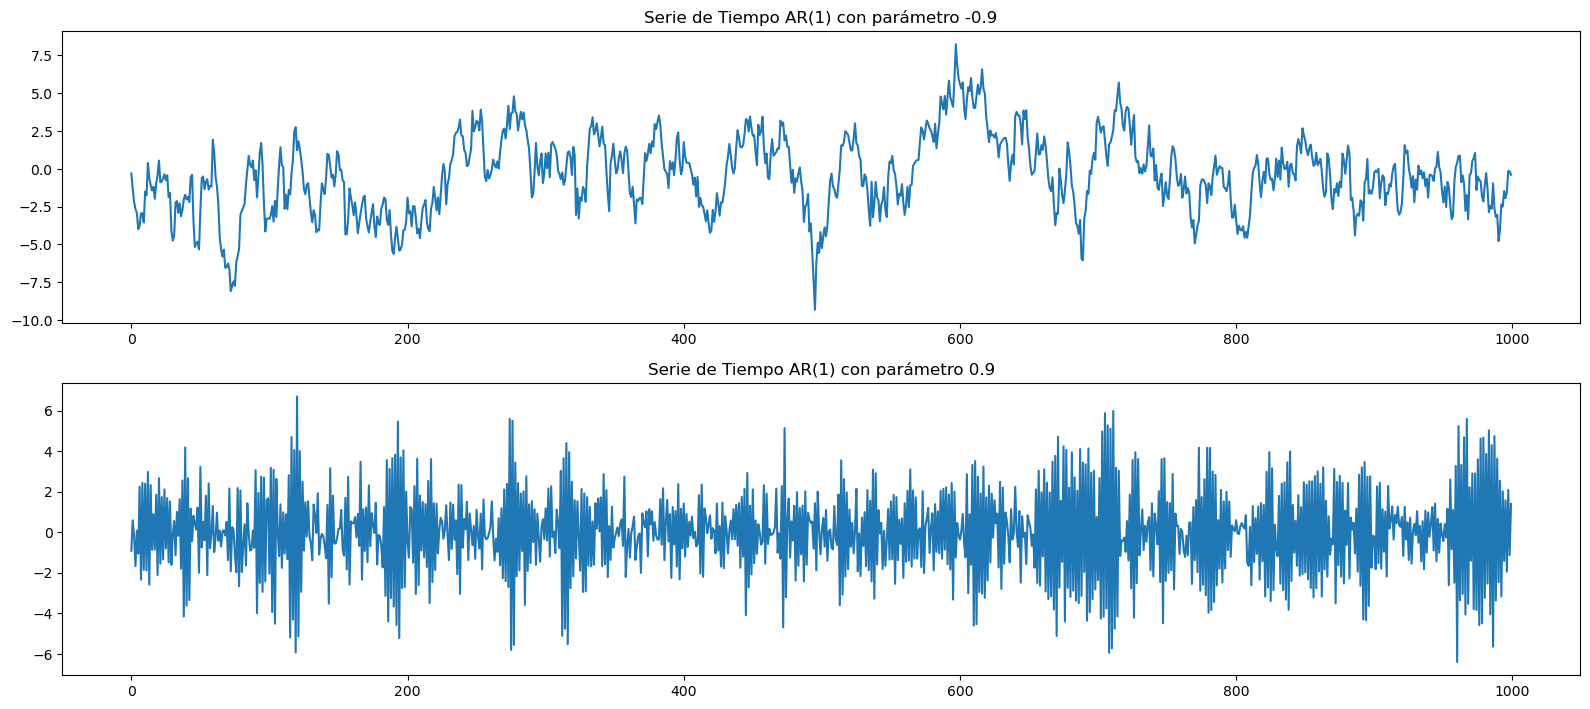

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 14)

plt.subplot(4,1,1)
# AR(1) con parámetro -0.9
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('Serie de Tiempo AR(1) con parámetro -0.9')
plt.plot(sim1)

# AR(1) con parámetro +0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('Serie de Tiempo AR(1) con parámetro 0.9')
plt.plot(sim2)

plt.tight_layout()
plt.show()



**Ahora se genera la misma serie, pero con AR(2)**

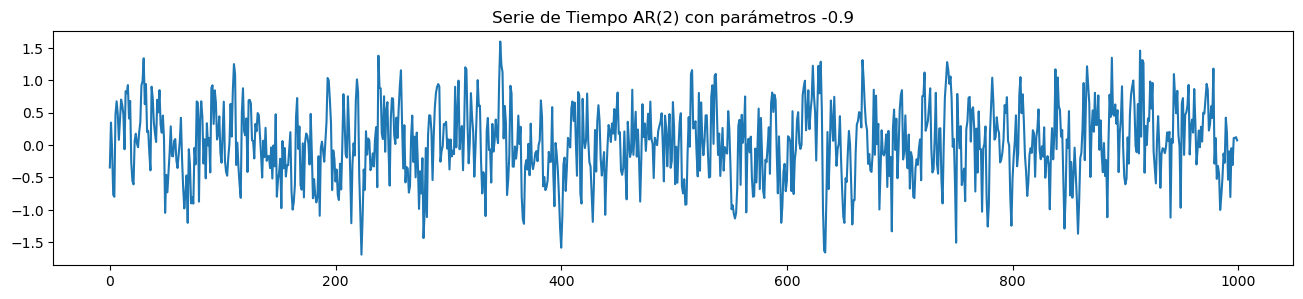

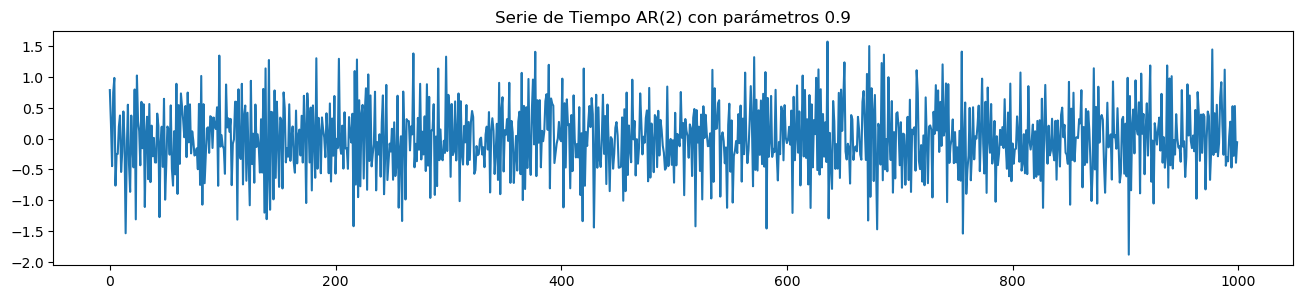

In [67]:
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9])
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('Serie de Tiempo AR(2) con parámetros -0.9')
plt.plot(sim3)
plt.show()

# AR(2) con parámetros -0.9 
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9])
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('Serie de Tiempo AR(2) con parámetros 0.9')
plt.plot(sim4)
plt.show()

# **Forecasting con AR**
- Se usa el model.fit para hacer la predicción automática.
- Se muestra como va iterando el proceso del fit hasta que llega un nivel de predicción adecuado.

In [68]:
# Order tiene los parámetros p y q del modelo AR y MA respectivamente

model = ARIMA(sim1, order=(1,0,0))  # (p,d,q) → aquí es AR(1)
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1427.439
Date:                Thu, 28 Aug 2025   AIC                           2860.879
Time:                        16:12:56   BIC                           2875.602
Sample:                             0   HQIC                          2866.475
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4351      0.361     -1.204      0.229      -1.144       0.273
ar.L1          0.9113      0.013     71.039      0.000       0.886       0.936
sigma2         1.0153      0.042     24.028      0.0

**Después del fit, podemos revisar cuáles fueron los parámetros a los que se llegó luego de la predicción e incluso gráficar**
- Recordar que los modelos AR y MA tienen parámetros p y q y se refieren al número de lags.

Para la predicción, lo que hace el modelo es buscar automáticamente los mejores parámetros de la serie que se pueden ver acá:

In [69]:
print('u={} , φ={} '.format(result.params[0], result.params[1]))
print(result.summary())

u=-0.43506901469561543 , φ=0.9113215315447009 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1427.439
Date:                Thu, 28 Aug 2025   AIC                           2860.879
Time:                        16:12:56   BIC                           2875.602
Sample:                             0   HQIC                          2866.475
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4351      0.361     -1.204      0.229      -1.144       0.273
ar.L1          0.9113      0.013     71.039      0.000       0.886       0.936
sigma

# **Explicación**
- ARMA (1,0) indica los parámetros usados en el modelo.
- Log likelihood, no tiene medida, pero mientras más algo mejor, si se compara entre modelos.
- AIC (Akaike Info Criteria), BIC (Bayesian Info Criteria), HQIC (Hannan-Quin Info Criteria).
- Buscar AIC con bajos valores, ya que este método toma en cuenta el principio de parsimonia (menos parámetros = mejor). Además toma en cuenta el cálculo de la máxima verosimilitud (log likelihood)
- BIC es parecido a AIC pero también toma en cuenta el número de filas del modelo. Mientras más bajo, mejor.
- HQIC, menos utilizado.

## **Tabla de Coeficientes**
- Coefficient. Shows the model (AR o MA). Lag (L1, L2)
- Std Err. Estimado del error del valor predicho. Muestra cuán fuerte es el efecto del error residual en los parámetros estimados.
- z = Coef / std err.
- P > z es el p-value del coeficiente. Si es mayor a 0.05 se debe tomar en cuenta ya que se puede estar usando un coeficiente no significativo.
- Las últimas columnas representan el intervalo de confianza: coef +/- error margin.

**Se muestra la predicción con un plot_predict**

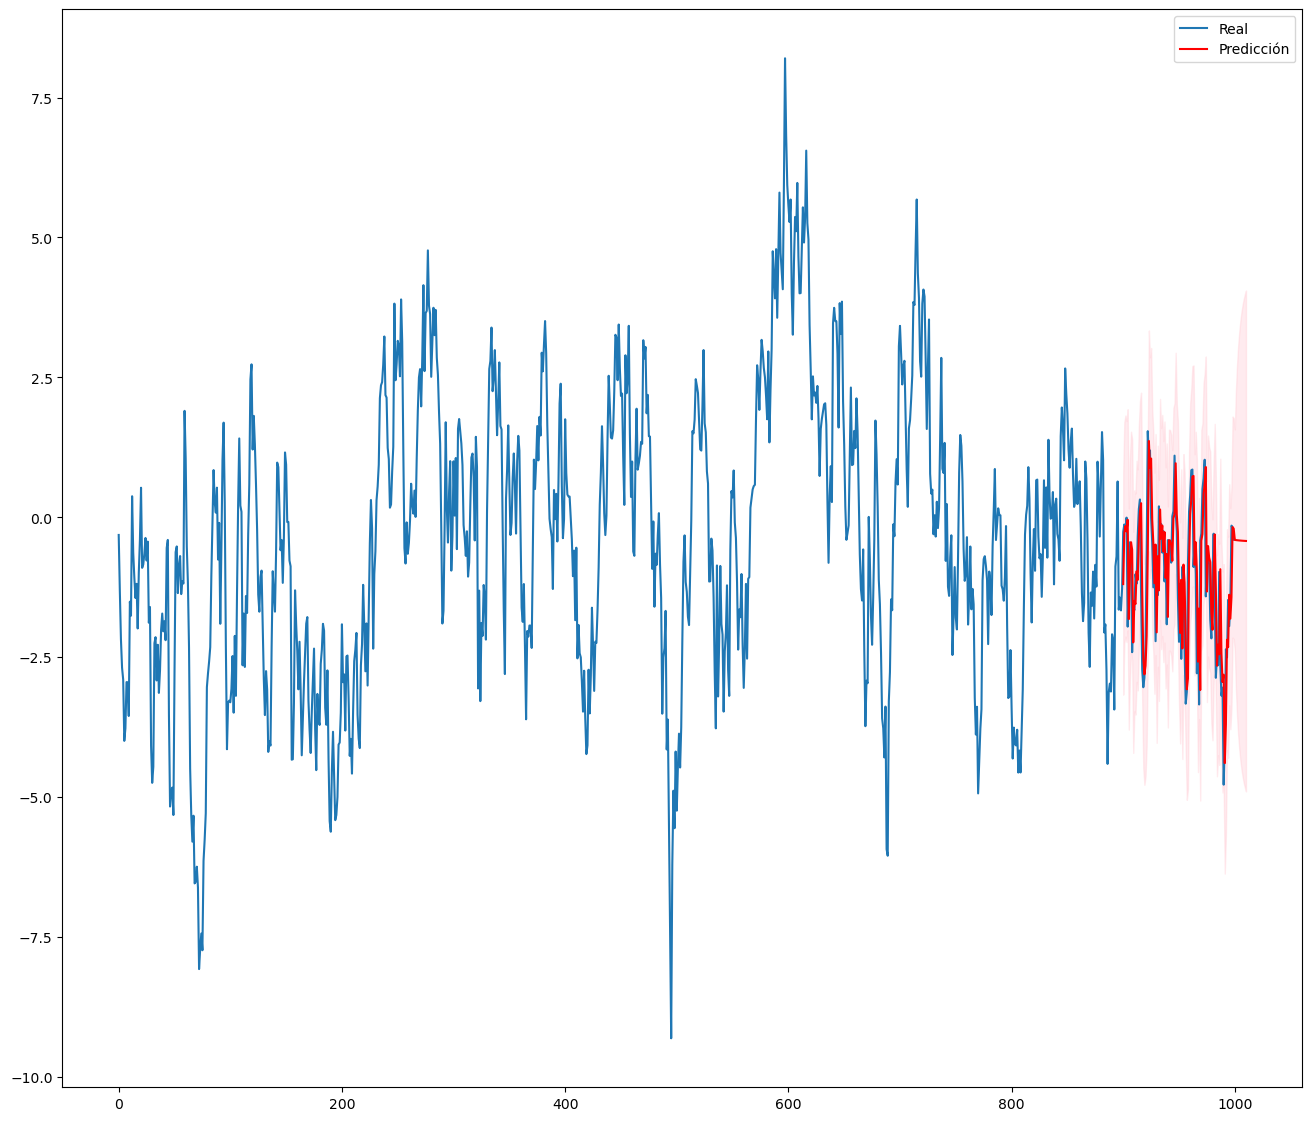

In [70]:
# convertir la serie simulada en pandas.Series con índice
sim1 = pd.Series(sim1)

# ahora entrenas tu modelo
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sim1, order=(1,0,0))
result = model.fit()

# predicciones
pred = result.get_prediction(start=900, end=1010, dynamic=False)

# serie real
plt.plot(sim1, label="Real")

# predicción puntual
plt.plot(pred.predicted_mean, label="Predicción", color="red")

# intervalo de confianza
conf_int = pred.conf_int()
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color="pink", alpha=0.3)

plt.legend()
plt.show()

**Se evalúa con RMSE**

In [75]:
y_true = sim1[900:1011].values
y_pred = result.predict(start=900, end=1010).values

# Ajustar al mínimo largo común
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE =", rmse)


RMSE = 1.0043012863652816


**Predicción de Precio de Google**

c:\Users\danielortega\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\danielortega\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\danielortega\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



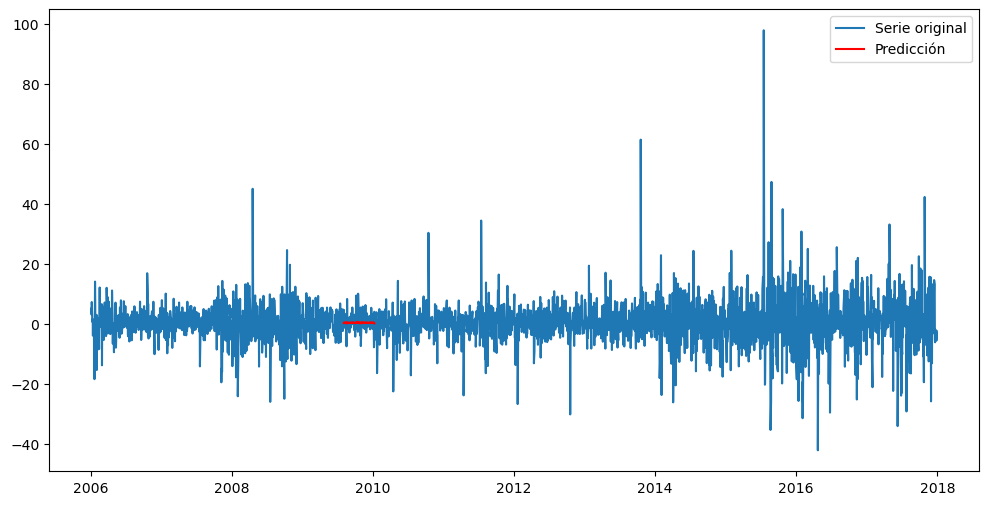

In [76]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Diferenciamos la serie (igual que antes con .diff())
serie = df_google['Close'].diff().dropna()

# Ajustamos un AR(1) que sería equivalente a ARMA(1,0)
model = ARIMA(serie, order=(1,0,0))
res = model.fit()

# Predicción (usa el índice de pandas en vez de índices numéricos)
start = 900
end = 1010
pred = res.predict(start=start, end=end)

# Graficamos
plt.figure(figsize=(12,6))
plt.plot(serie.index, serie, label="Serie original")
plt.plot(serie.index[start:end+1], pred, label="Predicción", color="red")
plt.legend()
plt.show()


___
# **GLOSARIO**

- **Autocorrelación**

Medida de la correlación de una serie temporal con sus propios valores pasados, utilizada para identificar patrones y dependencias temporales en los datos.

- **Movimiento Geométrico Browniano**

Modelo utilizado para predecir precios de acciones, caracterizado por su falta de memoria y dependencia de la volatilidad actual.

- **Modelo ARMA**

Combinación de modelos autorregresivos (AR) y promedios móviles (MA) para predecir series temporales univariables.

- **Modelo de Reversión a la Media**

Modelo que predice que las variables oscilan alrededor de un valor medio a largo plazo, utilizando parámetros como la velocidad de regresión. 

- **Modelo Vasicek**

Variación del modelo de reversión a la media, aplicado a la predicción de tasas de interés. 

- **Promedios Móviles (MAQ)**

Modelo que utiliza errores pasados para predecir series de tiempo, definido por el orden Q de la serie.

- **Ruido Blanco**

Secuencias aleatorias sin patrón, utilizada como referencia para evaluar la presencia de autocorrelación en una serie temporal.

- **Serie Autorregresiva**

Modelo que utiliza observaciones de periodos anteriores para predecir valores futuros, basado en una regresión de la variable consigo misma.

- **Simulación de Trayectorias**

Proceso aleatorio utilizado para generar posibles trayectorias de precios en modelos de predicción de series temporales-

- **Volatilidad**

Medida de la variabilidad de los precios en un mercado, utilizada en modelos de predicción para estimar la incertidumbre futura.